# Introduction

## Introduction to Ray

- **Open-source distributed scheduler** for stateless tasks & stateful actors  
- **Key features:** task graphs, resource-aware, fast data transfer, GPU/custom resources  
- **Infra:** in-memory object store, fault-tolerant design  
- **Ecosystem:** Data, Train, Tune, Serve, RLlib  
- **User-friendly Python APIs**


| Concept | What It Is | Why It Matters (The Problem It Solves) |
| :--- | :--- | :--- |
| **`@ray.remote`** | A decorator to mark Python code for parallel execution. | The magic switch to turn a normal function or class into a distributed building block. |
| **Task** | A remote, stateless function call. | **Problem:** My code is slow because it only uses one core. A Task lets you run a function on any available core. |
| **Actor** | A remote, stateful class instance. | **Problem:** My parallel tasks need to share and update a common state (like a counter or a model). |
| **`.remote()`** | The syntax used to execute a Task or an Actor method. | The command to "send this work to the Ray cluster" instead of running it here. |
| **`ObjectRef`** | A "future" or a "receipt" for a result being computed. | The placeholder you get back instantly after calling `.remote()`, allowing your code to continue without waiting. |
| **`ray.get()`** | The command to retrieve the actual result from an `ObjectRef`. | **Problem:** My parallel work has been sent out; now I need the final answers back. |
| **`ray.put()`** | A command to place a large object into shared memory. | **Problem:** Sending the same large dataset (e.g., a big model) to every task is slow and wasteful. |

In [1]:
!python code/sequential_process.py

Processed 8 images in 8.00 seconds.


In [5]:
!python code/parallel_process.py

2025-12-08 01:47:44,588	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.0.138.23:6379...
2025-12-08 01:47:44,599	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at https://session-mnqc1yx36k9vpkzivqkekde1w9.i.anyscaleuserdata.com 
2025-12-08 01:47:44,611	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_8ad1d8ecf50c4f8992e8e4bc1ca1b1930338d15b.zip' (2.73MiB) to Ray cluster...
2025-12-08 01:47:44,621	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_8ad1d8ecf50c4f8992e8e4bc1ca1b1930338d15b.zip'.
/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(
Processed 8 images in 3.75 seconds.


## Introduction to Ray Data

### Streaming execution

Ray Data processes large datasets efficiently using a streaming model, which works with **blocks** as the basic units of data.

This approach replaces traditional bulk processing, where the entire dataset and intermediate results had to fit in the cluster's memory.

For example:

Here is a batch inference pipeline with a bulk processing approach.

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/cko-2025-q1/batch-processing.png" width="800" alt="Traditional Batch Processing">

Note how:
- Execution is performed in stages
- The entire dataset can be repartitioned across stage boundaries

In contrast, here is the same batch inference pipeline with Ray Data's streaming model.

<img src="https://anyscale-materials.s3.us-west-2.amazonaws.com/cko-2025-q1/pipelining.png" width="800" alt="Streaming Model Pipelining">

Note how:
- Execution across stages of the pipeline is performed in parallel (i.e pipeline parallelism)
- Data is passed incrementally without blocking the pipeline

### Dataset and blocks

A Ray Dataset defines a data loading and processing pipeline.

When either "materialized" or "consumed", a Ray Dataset manifests as a distributed collection of blocks stored in the Ray Object Store.

Let's start by creating a materialized Ray Dataset to inspect its underlying blocks.

### Dataset and blocks

A Ray Dataset defines a data loading and processing pipeline.

When either "materialized" or "consumed", a Ray Dataset manifests as a distributed collection of blocks stored in the Ray Object Store.

Let's start by creating a materialized Ray Dataset to inspect its underlying blocks.

In [ ]:
!ray list objects

/home/ray/anaconda3/lib/python3.12/site-packages/ray/util/state/api.py:413: UserWarning: Callsite is not being recorded. To record callsite information for each ObjectRef created, set env variable RAY_record_ref_creation_sites=1 during `ray start` and `ray.init`.
  warnings.warn(warning_to_print)
No resource in the cluster


As expected, there are no objects created yet.

### Step 2: Prepare some data

Let's build a parquet dataset given a target in-memory size.

In [8]:
import gc
import ray
import numpy as np
import pandas as pd

In [9]:

size_mb = 64

df = pd.DataFrame(
    {
        "a": np.random.rand(size_mb * 1024**2 // 8).astype(np.float64),
    }
)

memory_usage = (df.memory_usage(deep=True) / 1024**2).sum() # in MiB
print(f"Memory usage: {memory_usage} MiB")

df.to_parquet("/mnt/cluster_storage/data.parquet")

Memory usage: 64.00012588500977 MiB


Let's inspect the parquet file.


In [10]:
!ls -lh /mnt/cluster_storage/data.parquet

-rw-r--r-- 1 ray users 67M Dec  8 01:58 /mnt/cluster_storage/data.parquet


### Step 3: Create a materialized dataset

Let's create a `Dataset` from the parquet file using `read_parquet`

In [11]:
ds = ray.data.read_parquet("/mnt/cluster_storage/data.parquet")
ds

2025-12-08 01:58:35,429	INFO worker.py:1837 -- Connecting to existing Ray cluster at address: 10.0.138.23:6379...
2025-12-08 01:58:35,441	INFO worker.py:2014 -- Connected to Ray cluster. View the dashboard at https://session-mnqc1yx36k9vpkzivqkekde1w9.i.anyscaleuserdata.com 
2025-12-08 01:58:35,449	INFO packaging.py:380 -- Pushing file package 'gcs://_ray_pkg_8b29056d63d58e533c462cf83fbcad5ef853e8d3.zip' (2.74MiB) to Ray cluster...
2025-12-08 01:58:35,460	INFO packaging.py:393 -- Successfully pushed file package 'gcs://_ray_pkg_8b29056d63d58e533c462cf83fbcad5ef853e8d3.zip'.
/home/ray/anaconda3/lib/python3.12/site-packages/ray/_private/worker.py:2062: FutureWarning: Tip: In future versions of Ray, Ray will no longer override accelerator visible devices env var if num_gpus=0 or num_gpus=None (default). To enable this behavior and turn off this error message, set RAY_ACCEL_ENV_VAR_OVERRIDE_ON_ZERO=0
  warnings.warn(


Dataset(num_rows=?, schema={a: double})

Let's materialize the `Dataset` using `materialize`

In [12]:
ds_materialized = ds.materialize()
ds_materialized

2025-12-08 01:58:59,424	INFO logging.py:397 -- Registered dataset logger for dataset dataset_1_0
2025-12-08 01:58:59,483	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_1_0. Full logs are in /tmp/ray/session_2025-12-08_01-21-22_884845_2352/logs/ray-data
2025-12-08 01:58:59,483	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_1_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles]
2025-12-08 01:58:59,487	INFO streaming_executor.py:682 -- [dataset]: A new progress UI is available. To enable, set `ray.data.DataContext.get_current().enable_rich_progress_bars = True` and `ray.data.DataContext.get_current().use_ray_tqdm = False`.


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

2025-12-08 01:58:59,508	WARNING resource_manager.py:136 -- ⚠️  Ray's object store is configured to use only 27.0% of available memory (17.3GiB out of 64.0GiB total). For optimal Ray Data performance, we recommend setting the object store to at least 50% of available memory. You can do this by setting the 'object_store_memory' parameter when calling ray.init() or by setting the RAY_DEFAULT_OBJECT_STORE_MEMORY_PROPORTION environment variable.
2025-12-08 01:59:05,301	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_1_0 execution finished in 5.82 seconds


MaterializedDataset(num_blocks=1, num_rows=8388608, schema={a: double})

### Step 4: List the objects again

We can see an object with a size of ~64 MiB has been created. 

In [13]:
!ray list objects

/home/ray/anaconda3/lib/python3.12/site-packages/ray/util/state/api.py:413: UserWarning: Callsite is not being recorded. To record callsite information for each ObjectRef created, set env variable RAY_record_ref_creation_sites=1 during `ray start` and `ray.init`.
  warnings.warn(warning_to_print)

======== List: 2025-12-08 01:59:12.060905 ========
Stats:
------------------------------
Total: 4

Table:
------------------------------
    OBJECT_ID                                                 OBJECT_SIZE    TASK_STATUS      ATTEMPT_NUMBER  REFERENCE_TYPE    CALL_SITE    TYPE      PID  IP
 0  00ffffffffffffffffffffffffffffffffffffff0600000001e1f505  530.000 B      FINISHED                      1  LOCAL_REFERENCE   disabled     DRIVER  15714  10.0.138.23
 1  00ffffffffffffffffffffffffffffffffffffff0600000002e1f505  9.604 KiB      FINISHED                      1  LOCAL_REFERENCE   disabled     DRIVER  15714  10.0.138.23
 2  00ffffffffffffffffffffffffffffffffffffff0600000003e1f505  4.089 K

Note that we can verify the object was indeed generated by a Ray Data task by following the `CALL_SITE` of the object.

### Step 5: Inspect the blocks

Instead of browsing through all the objects in the object store, we can directly fetch the blocks of a materialized dataset using Ray Data.

It turns out that we can iterate over the blocks of a dataset using `iter_internal_ref_bundles`.


In [14]:
for ref_bundle in ds_materialized.iter_internal_ref_bundles():
    print(ref_bundle)

RefBundle(1 blocks,
  8388608 rows,
  schema=a: double
-- schema metadata --
pandas: '{"index_columns": [{"kind": "range", "name": null, "start": 0, "' + 368,
  owns_blocks=False,
  blocks=(
    0: 8388608 rows, 68157440 bytes, slice=None (full block)
  )
)


A reference bundle `RefBundle` is simply a bundle of:
- a reference to the block
- metadata about the block

In [15]:
block_ref, block_metadata = ref_bundle.blocks[0]
block_ref

ObjectRef(bfc94244383a849dffffffffffffffffffffffff0600000002000000)

A block is the basic unit of data that Ray Data stores in the object store and transfers over the network. 

Each block contains a disjoint subset of rows, and Ray Data loads and transforms these blocks in a distributed manner.


<img src="https://docs.ray.io/en/latest/_images/dataset-arch.svg" width="600">


To fetch the block, we can use `ray.get`.

In [16]:
block = ray.get(block_ref)
block

pyarrow.Table
a: double
----
a: [[0.7989800163672041,0.6344185493885544,0.4917178156205806,0.9716590769962449,0.26914994984273954,...,0.9975608604691472,0.32284565911431407,0.49420912394415784,0.6268501322351306,0.7470937065673725],[0.45674585620322783,0.11224171767127555,0.46360835447723325,0.5695092033823468,0.5409990783281241,...,0.7882326944102539,0.875076092736608,0.0003137079180673963,0.5677898483000785,0.38242416136118806],...,[0.2949085046191595,0.9549014884507612,0.8752693566434566,0.7896903032570475,0.6737564829283317,...,0.37115260978496234,0.8920474730306769,0.6006101267009526,0.20159273471785444,0.35353564356215017],[0.25015303725618976,0.7131610439872852,0.5637070514359834,0.45483430537056013,0.7101607344274817,...,0.2775986709456847,0.25560240546019153,0.2733210535902404,0.5930519066755894,0.29204062033852796]]

Ray Data stores blocks as either pandas Dataframes or pyarrow Tables. In this case, when materializing from a `read_parquet`, the block is a pyarrow Table.

<!-- TODO - figure out adding info below: -->
<!-- Note, that regardless of the data type that Ray Data uses to store the block, Ray Data will convert the block to the required batch format when batching the data and transforming it. -->

In [17]:
type(block)

pyarrow.lib.Table

In this case, the block contains the same data as the original dataframe.

In [18]:
block.shape, df.shape

((8388608, 1), (8388608, 1))

let's clean up references to the objects we created so Ray can garbage collect them.

In [20]:
%xdel block
%xdel block_ref
%xdel ds
%xdel ds_materialized
%xdel ref_bundle
gc.collect()

1742

We can see that the object has been garbage collected.

In [21]:
!ray list objects

/home/ray/anaconda3/lib/python3.12/site-packages/ray/util/state/api.py:413: UserWarning: Callsite is not being recorded. To record callsite information for each ObjectRef created, set env variable RAY_record_ref_creation_sites=1 during `ray start` and `ray.init`.
  warnings.warn(warning_to_print)
No resource in the cluster


(autoscaler +2m32s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.


# What are we going to build today ? 

### At a high level, we'll look at using Ray Data today for...

* Scalable data ingestion
* Transforming data using Ray Data pipelines and operators
* Scalable batch inference processing with accelerators
* Joining Ray Datasets and apply data transformation to joined columns
* Integrating scalable LLM inference and fractional resource scheduling

### Batch image generation

#### Scenario

We have a dataset of image prompts (in our example, animals) and another dataset with enhanced detail information for each record (in the demo, clothing the animal will wear).

Our end goal is to combine the prompts and details, then use a LLM to enhance to prompts further, employ an image gen model to create corresponding images, and produce batch output to storage.

#### Ray Data motivation

It's pretty easy to write a Python script to manipulate strings and use models directly from Huggingface with code like the following:

```python
pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")

image = pipe("A cinematic shot of a racoon wearing an italian priest robe.", num_inference_steps=1, guidance_scale=0.0).images[0]

But we want to build a scalable data+AI processing pipeline. To do that, we want to ...

* leverage a scale-out cluster with multiple GPUs
* read data using as much of our cluster as is useful (parallel read)
* work with the data in chunks large enough to get benefits of scale (i.e., not suffer from excessive overhead relative to the number of records)
    * but also small enough to allow for flexible scheduling as it flows through our pipeline -- we don't want an enormous chunk to hold up processing, require excessive disk or network I/O, etc.
* assign work to, e.g., CPU nodes where GPU is not required; or to smaller, cheaper GPUs where large ones are not required
* adjust batching to optimize GPU use even when ideal batch size may be different for different operations
* handle arbitrarily large datasets by leveraging a streaming execution model
* minimize I/O costs by, e.g., fusing operations where possible
* produce predictable flow by managing backpressure (i.e., ensuring data doesn't "pile up" in between pipeline stages)
* optimize via lazy execution and flexible logical + physical planners

Ray Data is designed to address these requirements, allowing us to orchestrate at scale while still straightforward Python / Huggingface code we're used to.

### Agenda and steps for incremental implementation

1. Locate our datasets in shared storage
2. Read records using Ray Data and learn how to perform basic transformations
3. Generate images across multiple GPU nodes
4. Lab activity: generate images and store all of our prompts and outputs as parquet data
5. Join animal records against clothing outfit details to build a bigger prompt and generate enhanced images
6. Lab activity: generate and export just the images as PNG files
7. Leverage a LLM to further enhance the prompts, adding seasonal content and generate images from the full pipeline
8. Lab activity: parameterize the LLM-based component so see how Ray Data supports separation of concerns
9. Wrapup

# Let's start! 

In [30]:
from diffusers import AutoPipelineForText2Image
from transformers import pipeline
from transformers.utils import logging
import numpy as np
import random
import ray
import torch
logging.set_verbosity_info()

## `Step 0`: Defining the dataset 

First, we need to get all of our data in some common location where the whole cluster can see it. This might be a blob store, NFS, database, etc.

Anyscale offers `/mnt/cluster_storage` as a NFS path.

In [ ]:
!head data/animals.csv

id,animal
100,A watercolor painting of a cat
101,A digital illustration of a dog
102,A charcoal sketch of a rabbit
103,A clay sculpture of an owl
104,An oil painting of a fox
105,A pencil drawing of a horse
106,A digital painting of a penguin
107,A watercolor of a bear
108,An ink sketch of a raccoon


In [23]:
!cp data/animals.csv /mnt/cluster_storage/

## `Step 1`: Read the data using `Ray Data`

Ray Data's `read_xxxx` methods (see I/O in Ray Docs for all the available formats and data sources) get us scalable, parallel reads.

In [ ]:
animals = ray.data.read_csv('/mnt/cluster_storage/animals.csv')
animals.take_batch(3)

2025-12-08 02:08:03,758	INFO logging.py:397 -- Registered dataset logger for dataset dataset_4_0
2025-12-08 02:08:03,763	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_4_0. Full logs are in /tmp/ray/session_2025-12-08_01-21-22_884845_2352/logs/ray-data
2025-12-08 02:08:03,764	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_4_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=3 3: 0.00 row [00:00, ? row/s]

2025-12-08 02:08:05,513	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_4_0 execution finished in 1.75 seconds


{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object)}

We can rename column, like this: 

In [26]:
animals.rename_columns({'animal' : 'prompt'}) \
       .take_batch(3)

2025-12-08 02:11:08,803	INFO logging.py:397 -- Registered dataset logger for dataset dataset_6_0
2025-12-08 02:11:08,808	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_6_0. Full logs are in /tmp/ray/session_2025-12-08_01-21-22_884845_2352/logs/ray-data
2025-12-08 02:11:08,809	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_6_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=3] -> TaskPoolMapOperator[Project]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=3 3: 0.00 row [00:00, ? row/s]

- Project 4: 0.00 row [00:00, ? row/s]

2025-12-08 02:11:10,445	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_6_0 execution finished in 1.64 seconds


{'id': array([100, 101, 102]),
 'prompt': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object)}

In [ ]:
animals

Dataset(num_rows=?, schema=Unknown schema)

## `Step 2` : Generate Image 

Stateful tranformation of datasets -- in this example, AI inference where the state is the image gen model -- is done with the following pattern.

1. Define a Python class (which Ray will later instantiate across the cluster as one more actor instances to do the processing)
1. Use Dataset's `map_batches` API to tell Ray to send batches of data to the `__call__` method in the actors instances
    1. `map_batches` allows us to specify resource requirements, actor pool size, batch size, and more

In [29]:
class ImageGen():
    def __init__(self):
        self.pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16").to("cuda")
        
    def gen_image(self, prompts):
        return self.pipe(prompt=list(prompts), num_inference_steps=1, guidance_scale=0.0).images
    
    def __call__(self, batch):
        batch['image'] = self.gen_image(batch['prompt'])
        return batch

In [31]:
animals_images = animals.repartition(2) \
                        .rename_columns({'animal' : 'prompt'}) \
                        .map_batches(ImageGen, 
                                     num_gpus=1, 
                                     compute=ray.data.ActorPoolStrategy(size=2), 
                                     batch_size=8)

Ray Datasets employ *lazy evaluation* for improved performance, so we can use APIs like `take_batch`, `take`, or `show` to trigger execution for development and testing purposes.

In [ ]:
examples = animals_images.take_batch(3)

2025-12-08 02:21:00,126	INFO logging.py:397 -- Registered dataset logger for dataset dataset_12_0
2025-12-08 02:21:00,129	INFO limit_pushdown.py:140 -- Skipping push down of limit 3 through map MapBatches[MapBatches(ImageGen)] because it requires 8 rows to produce stable outputs
2025-12-08 02:21:00,133	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_12_0. Full logs are in /tmp/ray/session_2025-12-08_01-21-22_884845_2352/logs/ray-data
2025-12-08 02:21:00,134	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_12_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[Project] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- Repartition 3: 0.00 row [00:00, ? row/s]

Split Repartition 4:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Project 5: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 6: 0.00 row [00:00, ? row/s]

- limit=3 7: 0.00 row [00:00, ? row/s]

100%|██████████| 1/1 [00:00<00:00,  1.56it/s]5, ip=10.0.191.5) 
(MapWorker(MapBatches(ImageGen)) pid=8295, ip=10.0.191.5) Failed to convert column 'image' into pyarrow array due to: Error converting data to Arrow: [<PIL.Image.Image image mode=RGB size=512x512 at 0x709D149FDE50>, <PIL.Image.Image image mode=RGB size=512x512 at 0x709D13C32390>, <PIL.Image.Image image mode=RGB size=512x512 at 0x709D13C32450>, <PIL...; falling back to serialize as pickled python objects
(MapWorker(MapBatches(ImageGen)) pid=8295, ip=10.0.191.5) Traceback (most recent call last):
(MapWorker(MapBatches(ImageGen)) pid=8295, ip=10.0.191.5)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/air/util/tensor_extensions/arrow.py", line 318, in _convert_to_pyarrow_native_array
(MapWorker(MapBatches(ImageGen)) pid=8295, ip=10.0.191.5)     pa_type = _infer_pyarrow_type(column_values)
(MapWorker(MapBatches(ImageGen)) pid=8295, ip=10.0.191.5)               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(MapWorker(MapBatch

100%|██████████| 1/1 [00:00<00:00, 12.64it/s]5, ip=10.0.191.5) 


In [35]:
examples

{'id': array([100, 101, 102]),
 'prompt': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'image': array([<PIL.Image.Image image mode=RGB size=512x512 at 0x7D2063B0EF90>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x7D2063B0C440>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x7D2063B0C4D0>],
       dtype=object)}

A watercolor painting of a cat


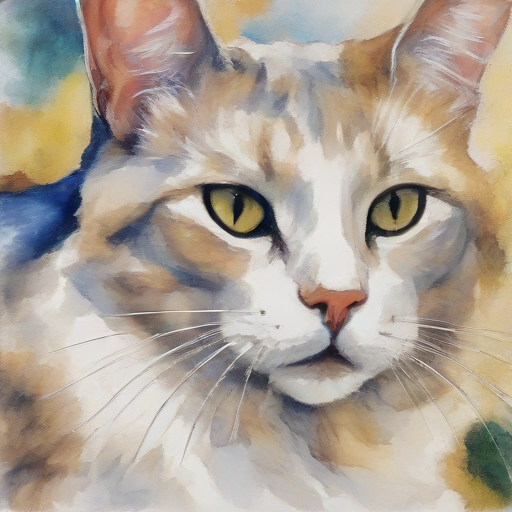

In [40]:
print(examples['prompt'][0])
examples['image'][0]


<div style="border: 2px solid #4F8EF7; background: #F3F8FF; border-radius: 10px; padding: 18px; margin: 18px 0;">
<h2 style="color: #25396f; margin-top: 0;">📝 <span style="color:#3971CC;">Lab:</span> Generate and Write All Output to Storage as <span style="color: #C678DD;">Parquet</span> Data</h2>

<ul style="font-size: 1.1em;">
  <li><b>Start</b> with the <span style="color: #A9A9A9;">Ray Dataset</span> you'd like to write.</li>
  <li><b>Check</b> the <a href="https://docs.ray.io/en/latest/data/api/input_output.html" target="_blank" style="color: #3971CC;">Ray Data Write API docs</a> to find a suitable <code>write</code> API.</li>
  <li><b>Remember</b> to write to a <span style="color: #228B22;">shared file location</span>, such as <code style="color: #228B22;">/mnt/cluster_storage</code>.</li>
</ul>
</div>

In [42]:
# try your code here


<details>
    <summary style="font-size: 1.5em; color: ;"><b> Solution</b></summary>
 
 ```python
 animals_images.write_parquet('/mnt/cluster_storage/animals_images.parquet/')
 ```
</details>


## `Step 3`: Improving the `prompt` using `JOIN`

Ray Data supports a number of high-performance JOIN APIs.  
You can learn more here:  [Ray Data Join API Documentation](https://docs.ray.io/en/latest/data/joining-data.html)

We can use a `JOIN` to connect our `animal` records with a detailed prompt refinement unique to that record.

In [48]:
!head /mnt/cluster_storage/outfits.csv

id,outfit
100,red scarf
101,blue jacket
102,green hat
103,purple cloak
104,yellow sweater
105,pink blanket
106,orange bowtie
107,teal hoodie
108,violet vest


In [49]:
outfits = ray.data.read_csv('/mnt/cluster_storage/outfits.csv')
outfits.take_batch(3)

2025-12-08 02:37:20,397	INFO logging.py:397 -- Registered dataset logger for dataset dataset_17_0
2025-12-08 02:37:20,401	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_17_0. Full logs are in /tmp/ray/session_2025-12-08_01-21-22_884845_2352/logs/ray-data
2025-12-08 02:37:20,402	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_17_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- limit=3 3: 0.00 row [00:00, ? row/s]

2025-12-08 02:37:21,958	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_17_0 execution finished in 1.56 seconds


{'id': array([100, 101, 102]),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object)}

In [50]:
animals_outfits = animals.join(outfits, 'inner', 1) \
                         .repartition(8)

animals_outfits.take_batch(3)

2025-12-08 02:37:52,572	INFO logging.py:397 -- Registered dataset logger for dataset dataset_20_0
/home/ray/anaconda3/lib/python3.12/site-packages/ray/anyscale/data/_internal/util/dependencies.py:42: UserWarning: Numba isn't available. Install numba>=0.61>=0.61 to get better performance for hash partitioning operations. Falling back to slower Python implementation for RayTurbo optimizations.
  warnings.warn(
2025-12-08 02:37:52,582	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_20_0. Full logs are in /tmp/ray/session_2025-12-08_01-21-22_884845_2352/logs/ray-data
2025-12-08 02:37:52,582	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_20_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWithPolars[Join(num_partitions=1)] -> AllToAllOperator[Repartition] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- limit=3 10: 0.00 row [00:00, ? row/s]

2025-12-08 02:37:56,186	INFO streaming_executor.py:300 -- ✔️  Dataset dataset_20_0 execution finished in 3.60 seconds


{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object)}

In [52]:
# Expand the prompt to include the outfit
def expand_prompt(batch):
    batch['prompt'] = batch['animal'] + ' wearing a ' + batch['outfit']
    return batch

# Generate images for the dressed animals
dressed_animals = animals_outfits.map_batches(expand_prompt) \
                                 .map_batches(ImageGen, 
                                              batch_size=16, 
                                              compute=ray.data.ActorPoolStrategy(size=2), 
                                              num_gpus=1)

In [ ]:
# Take a look at the first 3 records
examples = dressed_animals.take_batch(3)

2025-12-08 02:42:52,633	INFO logging.py:397 -- Registered dataset logger for dataset dataset_27_0
2025-12-08 02:42:52,636	INFO limit_pushdown.py:140 -- Skipping push down of limit 3 through map MapBatches[MapBatches(ImageGen)] because it requires 16 rows to produce stable outputs
2025-12-08 02:42:52,642	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_27_0. Full logs are in /tmp/ray/session_2025-12-08_01-21-22_884845_2352/logs/ray-data
2025-12-08 02:42:52,643	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_27_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWithPolars[Join(num_partitions=1)] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(expand_prompt)] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> LimitOperator[limit=3]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(expand_prompt) 10: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 11: 0.00 row [00:00, ? row/s]

- limit=3 12: 0.00 row [00:00, ? row/s]

100%|██████████| 1/1 [00:00<00:00,  1.28it/s]68, ip=10.0.136.28) 
(MapWorker(MapBatches(ImageGen)) pid=11621, ip=10.0.191.5) Failed to convert column 'image' into pyarrow array due to: Error converting data to Arrow: [<PIL.Image.Image image mode=RGB size=512x512 at 0x71DF8B623EC0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x71DF8927F0B0>, <PIL.Image.Image image mode=RGB size=512x512 at 0x71DF8ACE3380>, <PIL...; falling back to serialize as pickled python objects
(MapWorker(MapBatches(ImageGen)) pid=11621, ip=10.0.191.5) Traceback (most recent call last):
(MapWorker(MapBatches(ImageGen)) pid=11621, ip=10.0.191.5)   File "/home/ray/anaconda3/lib/python3.12/site-packages/ray/air/util/tensor_extensions/arrow.py", line 318, in _convert_to_pyarrow_native_array
(MapWorker(MapBatches(ImageGen)) pid=11621, ip=10.0.191.5)     pa_type = _infer_pyarrow_type(column_values)
(MapWorker(MapBatches(ImageGen)) pid=11621, ip=10.0.191.5)               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
(MapWorker(M

100%|██████████| 1/1 [00:00<00:00,  3.89it/s]68, ip=10.0.136.28) 


In [57]:
examples

{'id': array([100, 101, 102]),
 'animal': array(['A watercolor painting of a cat',
        'A digital illustration of a dog', 'A charcoal sketch of a rabbit'],
       dtype=object),
 'outfit': array(['red scarf', 'blue jacket', 'green hat'], dtype=object),
 'prompt': array(['A watercolor painting of a cat wearing a red scarf',
        'A digital illustration of a dog wearing a blue jacket',
        'A charcoal sketch of a rabbit wearing a green hat'], dtype=object),
 'image': array([<PIL.Image.Image image mode=RGB size=512x512 at 0x7D216DE9A6C0>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x7D216DF7F7D0>,
        <PIL.Image.Image image mode=RGB size=512x512 at 0x7D216DE8F470>],
       dtype=object)}

A charcoal sketch of a rabbit wearing a green hat


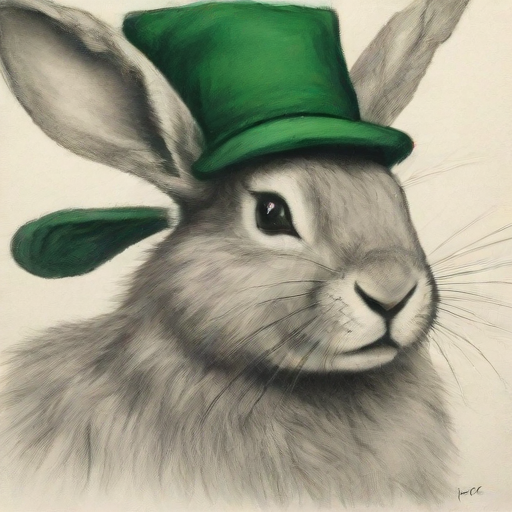

In [61]:
print(examples['prompt'][2])
examples['image'][2]

<div style="border: 2px solid #4F8EF7; background: #F3F8FF; border-radius: 10px; padding: 18px; margin: 18px 0;">
<h2 style="color: #25396f; margin-top: 0;">📝 <span style="color:#3971CC;">Lab:</span> Generate Images for Input Prompts &amp; Write Them to a Folder</h2>

<ul style="font-size: 1.1em;">
  <li><b>Convert</b> the image column to NumPy arrays using <code>np.array(my_pil_image)</code> together with <code>map_batches</code>.</li>
  <li><b>Use</b> <code>dataset.write_images(...)</code> to write the NumPy image arrays to a folder of your choice (e.g., <code>/mnt/cluster_storage/generated_images/</code>).</li>
  <li><b>Check</b> the <a href="https://docs.ray.io/en/latest/data/api/input_output.html#ray.data.Dataset.write_images" target="_blank" style="color: #3971CC;">Ray Data Write Images API Docs</a> for details.</li>
</ul>
</div>

In [62]:
# try your code here


<details>
    <summary style="font-size: 1.5em; color: ;"><b> Solution</b></summary>
 
 ```python
    def image_to_array(batch):
        batch['image'] = [np.array(i) for i in batch['image']]
        return batch
        
    dressed_animals.map_batches(image_to_array) \
                   .write_images('/mnt/cluster_storage/animals_images/', 'image')
 ```
</details>


## `Step 4` :  Enhance pipeline with `LLM` generated prompt

We can leverage a LLM to create more varied and detailed image prompts -- as well as add dynamism like a seasonal element -- by adding a LLM batch inference step to the pipeline.

To implement this operation, we'll
1. Create a Python class to encasulate the logic and data transformtion
1. Use `map_batches` to route batches of data from our Ray Dataset through this transformation operation
1. Demonstrate Ray's support for fractional resource allocation, so that we can schedule 4 GPU-dependent operator instances with only 2 GPUs
1. Demonstrate the decoupling of operator batch sizes from each other (as well as from Dataset block size) to optimally use our models and GPUs

In [66]:
class Enhancer():
    def __init__(self):
        self.pipe = pipeline("text-generation", model="Qwen/Qwen2.5-0.5B-Instruct", device='cuda')
        
    def chat(self, prompts):
        messages = []
        for p in prompts:
            season = random.choice(['winter', 'spring', 'summer', 'fall'])
                                   
            message = [{"role": "system", "content": "You are a helpful assistant." +
                        "Enhance the image description with two short elements corresponding to the " + season + 
                        "season. Keep animal wearing clothing and retain image medium information (like photo or painting). Return new description only, no intro."},
                        {"role": "user", "content": p }]
            messages.append(message)
        return [out[0]['generated_text'][-1]['content'] for out in self.pipe(messages, max_new_tokens=200, batch_size=2)]
    
    def __call__(self, batch):
        batch['prompt'] = self.chat(batch['prompt'])
        return batch

In [68]:
seasonal_images = animals_outfits.map_batches(expand_prompt) \
                                 .map_batches(Enhancer, batch_size=4, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.6) \
                                 .map_batches(ImageGen, batch_size=8, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.4)

In [69]:
examples = seasonal_images.take_batch(5)

2025-12-08 02:57:48,984	INFO logging.py:397 -- Registered dataset logger for dataset dataset_39_0
2025-12-08 02:57:48,988	INFO limit_pushdown.py:140 -- Skipping push down of limit 5 through map MapBatches[MapBatches(ImageGen)] because it requires 8 rows to produce stable outputs
2025-12-08 02:57:48,996	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_39_0. Full logs are in /tmp/ray/session_2025-12-08_01-21-22_884845_2352/logs/ray-data
2025-12-08 02:57:48,997	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_39_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWithPolars[Join(num_partitions=1)] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(expand_prompt)] -> ActorPoolMapOperator[MapBatches(Enhancer)] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> LimitOperator[limit=5]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(expand_prompt) 10: 0.00 row [00:00, ? row/s]

- MapBatches(Enhancer) 11: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 12: 0.00 row [00:00, ? row/s]

- limit=5 13: 0.00 row [00:00, ? row/s]

Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  5.19it/s]
(MapWorker(MapBatches(Enhancer)) pid=12793, ip=10.0.191.5) Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  3.71it/s]
(MapWorker(MapBatches(Enhancer)) pid=12793, ip=10.0.191.5) Device set to use cuda
(MapWorker(MapBatches(Enhancer)) pid=12793, ip=10.0.191.5) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:01<00:00,  4.37it/s] [repeated 3x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=13469, ip=10.0.136.28) Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
(MapWorker(MapBatches(Enhancer)) pid=13469, ip=10.0.136.28) Device set to use cuda
(MapWor

In the autumn season, an exquisite printmaking piece captures the essence of a sea otter adorned in a luxurious plum-colored sweater, symbolizing both its grace and the enduring beauty of nature's hues. The piece is rendered in watercolor on a canvas, capturing the subtle nuances of the sea otter's fur against the vibrant backdrop of the autumn leaves.


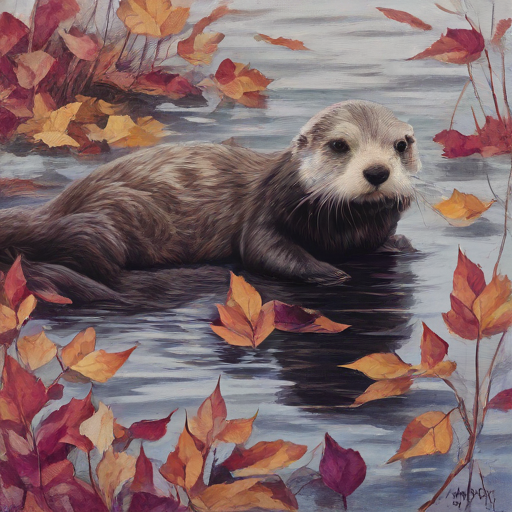

(MapWorker(MapBatches(Enhancer)) pid=12793, ip=10.0.191.5) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
(MapWorker(MapBatches(Enhancer)) pid=12793, ip=10.0.191.5) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 4x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=13469, ip=10.0.136.28) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 4x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=13469, ip=10.0.136.28) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 3x

In [70]:
print(examples['prompt'][0])
examples['image'][0]


## Lab: Modify the `Enhancer` class and `seasonal_images` pipeline for parametrization

* Use variables contaioning the model name and the name of the dataset column containing the prompt as below

In [ ]:
enhancer_model = "Qwen/Qwen2.5-0.5B-Instruct"
prompt_column = "prompt"

In [ ]:
# try your code here: updated Enhancer class


In [ ]:
# try your code here: updated pipelineto generate seasonal_images Ray dataset


<details>
    <summary style="font-size: 1.5em; color: ;"><b> Solution</b></summary>
 
 ```python
    # try your code here: updated Enhancer class
    class Enhancer():
        def __init__(self, model_name, prompt_column_name):
            self.pipe = pipeline("text-generation", model=model_name, device='cuda')
            self.prompt_column_name = prompt_column_name
            
        def chat(self, prompts):
            messages = []
            for p in prompts:
                season = random.choice(['winter', 'spring', 'summer', 'fall'])
                                    
                message = [{"role": "system", "content": "You are a helpful assistant." +
                            "Enhance the image description with two short elements corresponding to the " + season + 
                            "season. Keep animal wearing clothing and retain image medium information (like photo or painting). Return new description only, no intro."},
                            {"role": "user", "content": p }]
                messages.append(message)
            return [out[0]['generated_text'][-1]['content'] for out in self.pipe(messages, max_new_tokens=200, batch_size=2)]
        
        def __call__(self, batch):
            batch[self.prompt_column_name] = self.chat(batch[self.prompt_column_name])
            return batch


    # try your code here: updated pipelineto generate seasonal_images Ray dataset
    seasonal_images = animals_outfits.map_batches(expand_prompt) \
                        .map_batches(Enhancer, batch_size=4, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.6, fn_constructor_args=[enhancer_model, prompt_column]) \
                        .map_batches(ImageGen, batch_size=8, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.4)
 ```
</details>

In [72]:
# try your code here: updated Enhancer class
class Enhancer():
    def __init__(self, model_name, prompt_column_name):
        self.pipe = pipeline("text-generation", model=model_name, device='cuda')
        self.prompt_column_name = prompt_column_name
        
    def chat(self, prompts):
        messages = []
        for p in prompts:
            season = random.choice(['winter', 'spring', 'summer', 'fall'])
                                   
            message = [{"role": "system", "content": "You are a helpful assistant." +
                        "Enhance the image description with two short elements corresponding to the " + season + 
                        "season. Keep animal wearing clothing and retain image medium information (like photo or painting). Return new description only, no intro."},
                        {"role": "user", "content": p }]
            messages.append(message)
        return [out[0]['generated_text'][-1]['content'] for out in self.pipe(messages, max_new_tokens=200, batch_size=2)]
    
    def __call__(self, batch):
        batch[self.prompt_column_name] = self.chat(batch[self.prompt_column_name])
        return batch


In [73]:
# try your code here: updated pipelineto generate seasonal_images Ray dataset
seasonal_images = animals_outfits.map_batches(expand_prompt) \
                    .map_batches(Enhancer, batch_size=4, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.6, fn_constructor_args=[enhancer_model, prompt_column]) \
                    .map_batches(ImageGen, batch_size=8, compute=ray.data.ActorPoolStrategy(size=2), num_gpus=0.4)

In [74]:
examples = seasonal_images.take_batch(4)

2025-12-08 03:02:17,933	INFO logging.py:397 -- Registered dataset logger for dataset dataset_43_0
2025-12-08 03:02:17,935	INFO limit_pushdown.py:140 -- Skipping push down of limit 4 through map MapBatches[MapBatches(ImageGen)] because it requires 8 rows to produce stable outputs
2025-12-08 03:02:17,943	INFO streaming_executor.py:174 -- Starting execution of Dataset dataset_43_0. Full logs are in /tmp/ray/session_2025-12-08_01-21-22_884845_2352/logs/ray-data
2025-12-08 03:02:17,944	INFO streaming_executor.py:175 -- Execution plan of Dataset dataset_43_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles], InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> JoinOperatorWithPolars[Join(num_partitions=1)] -> AllToAllOperator[Repartition] -> TaskPoolMapOperator[MapBatches(expand_prompt)] -> ActorPoolMapOperator[MapBatches(Enhancer)] -> ActorPoolMapOperator[MapBatches(ImageGen)] -> LimitOperator[limit=4]


Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- ListFiles 3: 0.00 row [00:00, ? row/s]

- ReadFiles 4: 0.00 row [00:00, ? row/s]

- Join(num_partitions=1) 5: 0.00 row [00:00, ? row/s]

Shuffle 6:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

Join 7:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- Repartition 8: 0.00 row [00:00, ? row/s]

Split Repartition 9:   0%|          | 0.00/1.00 [00:00<?, ? row/s]

- MapBatches(expand_prompt) 10: 0.00 row [00:00, ? row/s]

- MapBatches(Enhancer) 11: 0.00 row [00:00, ? row/s]

- MapBatches(ImageGen) 12: 0.00 row [00:00, ? row/s]

- limit=4 13: 0.00 row [00:00, ? row/s]

(MapWorker(MapBatches(Enhancer)) pid=14107, ip=10.0.136.28) Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  8.29it/s]
(MapWorker(MapBatches(Enhancer)) pid=14107, ip=10.0.136.28) Device set to use cuda
(MapWorker(MapBatches(Enhancer)) pid=14107, ip=10.0.136.28) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
(MapWorker(MapBatches(Enhancer)) pid=13934, ip=10.0.191.5) Sliding Window Attention is enabled but not implemented for `sdpa`; unexpected results may be encountered.
Loading pipeline components...:  57%|█████▋    | 4/7 [00:00<00:00,  7.25it/s] [repeated 2x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=13934, ip=10.0.191.5) Device set to use cuda
(MapWorker(MapBatches(Enhancer)) pid=13934, ip=10.0.191.5) A decoder-only architectu

"A striking printmaking piece depicting a sea otter adorned in a plump, cozy sweater from the autumn season, capturing the essence of this iconic creature's attire during the warm months. The sweater is intricately hand-painted with soft, flowing lines that evoke the natural beauty of the ocean. The sea otter itself is depicted with a serene expression, likely looking out into the water, its fur slightly wet from the brisk autumn breeze. This piece would be ideal for displaying as an educational resource on marine life and the changing seasons, showcasing how animals adapt their appearance to suit their environment during the fall."

A striking printmaking piece depicting a sea otter adorned in a plump, cozy sweater from the autumn season, capturing the essence of this iconic creature's attire during the warm months. The sweater is intricately hand-painted with soft, flowing lines that evoke the natural beauty of the ocean. The sea otter itself is depicted with a serene expression, likely looking out into the water, its fur slightly wet from the brisk autumn breeze. This piece would be ideal for displaying as an educational resource on marine life and the changing seasons, showcasing how animals adapt their appearance to suit their environment during the fall.


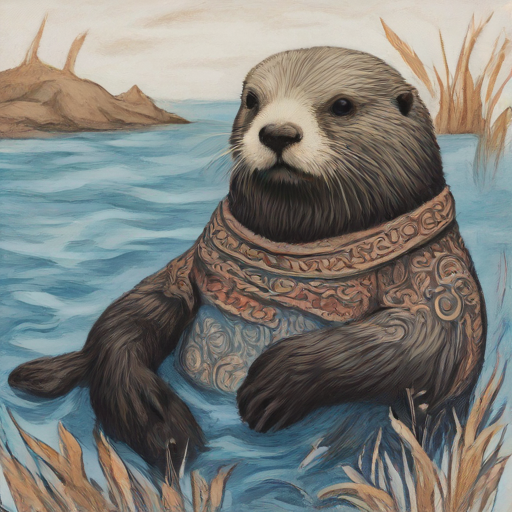

(MapWorker(MapBatches(Enhancer)) pid=14107, ip=10.0.136.28) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
(MapWorker(MapBatches(Enhancer)) pid=14107, ip=10.0.136.28) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 4x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=13934, ip=10.0.191.5) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 3x across cluster]
(MapWorker(MapBatches(Enhancer)) pid=14107, ip=10.0.136.28) A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer. [repeated 4

In [ ]:
print(examples['prompt'][0])
examples['image'][0]